# Digit Recognizer
This is a simple image classification challenge using the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). Lets see if we can train a classifier that can accurately distinguish handwritten digits.

<img src="images/MnistExamples.png">

### Goal
The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
For every in the test set, you should predict the correct label.

### Metric
This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import tensorflow as tf

Loading **taining** and **testing** data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Seperating features (images : X) and labels (correct digit labels: y)

In [3]:
y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1); del train

## 1. Data exploration

Checking the count of each label

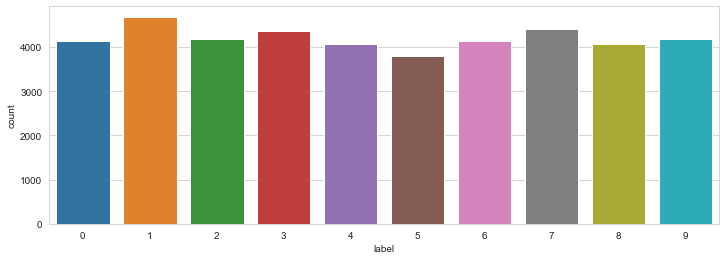

In [4]:
plt.figure(figsize=(12, 4))
sns.countplot(y_train)

In [5]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

We can see that there are more or less similar number of images for each digit. So its less likely that our classifier will get biased due to representation error (eg: suppose the digit 5 being predicted most of the time because there are a larger number of images of 5s in our dataset compared to other numbers).

## 2. Data preparation

### 2.1 Reshaping images
The images are currently flattened: 28x28 grayscale images flattened = 784 pixels. This is so that it is easier to pass into traditional Machine Learning classifiers such as SVCs or Random Forest classifiers. However, for image data Convolutional Neural Networks (CNNs) are currently the best choice. Therefore, we will reshape the images into their original dimensions: 28x28x1 (1 channel).

In [6]:
X_train = X_train.values.reshape(-1, 28, 28, 1) # Training images
test = test.values.reshape(-1, 28, 28, 1)       # Test set

Checking a few random images:

4		9		6		8		5		

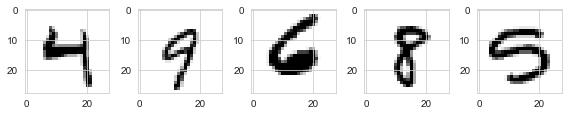

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 8))
for i in range(5):
    index = np.random.randint(0, len(X_train)-1)
    axes[i].imshow(X_train[index][:, :, 0], cmap='binary')
    print(y_train[index], end="\t\t")
fig.tight_layout()

### 2.2 Normalization
We will normalize the images to reduce the impact of alpha differences. Normalization also helps models converge faster.

In [8]:
X_train = X_train / 255.0
test = test / 255.0

Checking impact of normalization on images:

6		3		7		2		6		

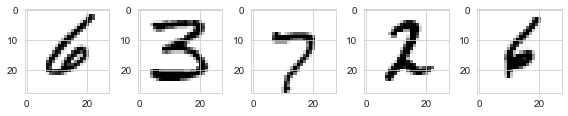

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 8))
for i in range(5):
    index = np.random.randint(0, len(X_train)-1)
    axes[i].imshow(X_train[index][:, :, 0], cmap='binary')
    print(y_train[index], end="\t\t")
fig.tight_layout()

Normalization doesn't fundamentally change our image. It only shifts the pixel values so that they have mean of 0 and standard deviation of 1.

### 2.3 One-hot encoding for labels
One-hot encoding is a process by which categorical variables like $[cat, dog]$ or $[0, 1, 2,...,9]$ are converted into one-hot vectors. 

In this case, we have 10 classes - the numbers 0-9. Now, suppose a random image label $ y_i = 5 $, one-hot encoding will represent this as a one-hot vector $[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$, similarly if $ y_i = 0 $, it will be represented as $[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]$.

In [10]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto')

Y_train = enc.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()

Original label, $ y_0 $:

In [14]:
y_train[0]

1

After one-hot encoding, $Y_0$:

In [11]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

Image, $X_0$:

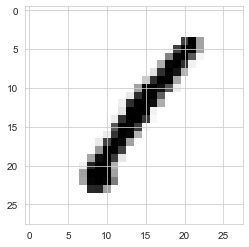

In [12]:
plt.imshow(X_train[0][:, :, 0], cmap='binary')

We can see that the labels are now represented differently. Instead of a single integer, it is now represented by a one-hot vector.

### 2.4 Seperating training data into training and validation sets

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)